# Convolutional Neural Networks
### Sign Language ASL

### Kernel created by [Abhishek Samanta](https://www.kaggle.com/abhishek60) and [Aheli Saha](https://www.kaggle.com/ahelis)

# Architecture

##### CONV - 3X3 filters, Stride - 1
##### POOL - maxpool, 2x2 filters, Stride - 2
#### INPUT -> CONV 16 -> POOL -> CONV 32 -> POOL -> CONV 64 -> CONV 64 ->POOL-> FC -> FC -> FC

# Import

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.contrib.layers import flatten

# Reading Input

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['american_sign_language.PNG', 'sign_mnist_test', 'amer_sign3.png', 'sign_mnist_train.csv', 'sign_mnist_test.csv', 'amer_sign2.png', 'sign_mnist_train']


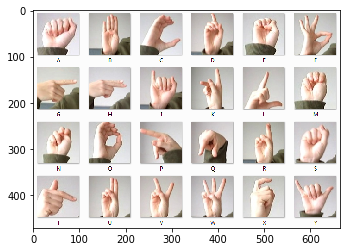

In [3]:
img1 = plt.imread("../input/amer_sign2.png")
plt.imshow(img1)

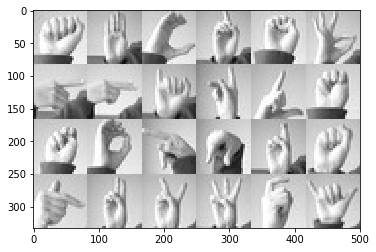

In [4]:
img2 = plt.imread("../input/amer_sign3.png")
plt.imshow(img2)

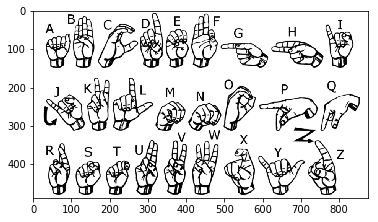

In [5]:
img3 = plt.imread("../input/american_sign_language.PNG")
plt.imshow(img3)

In [6]:
train_x = pd.read_csv("../input/sign_mnist_train.csv")
print(train_x.head())
test_x = pd.read_csv("../input/sign_mnist_test.csv")
print(test_x.head())

   label  pixel1  pixel2    ...     pixel782  pixel783  pixel784
0      3     107     118    ...          204       203       202
1      6     155     157    ...          103       135       149
2      2     187     188    ...          195       194       195
3      2     211     211    ...          222       229       163
4     13     164     167    ...          163       164       179

[5 rows x 785 columns]
   label  pixel1  pixel2    ...     pixel782  pixel783  pixel784
0      6     149     149    ...          112       120       107
1      5     126     128    ...          184       182       180
2     10      85      88    ...          225       224       222
3      0     203     205    ...          240       253       255
4      3     188     191    ...           46        46        53

[5 rows x 785 columns]


# Pre-processing

In [7]:
y_train = train_x['label'].values
train_x = train_x.drop('label',axis=1).values

In [8]:
y_test = test_x['label'].values
test_x = test_x.drop('label',axis=1).values

In [9]:
print(y_train.shape)
train_y = np.eye(25)[y_train]  #one hot encoding
print(train_y.shape)
test_y = np.eye(25)[y_test]

train_x = train_x/255.0  #normalization of training set
test_x = test_x/255.0  #normalization of test set

train_x = train_x.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)

(27455,)
(27455, 25)


In [10]:
print('Shape of train_x \t: ', train_x.shape)
print('Shape of train_y \t: ', train_y.shape)
print('Shape of test_x  \t: ', test_x.shape)
print('Shape of test_y  \t: ', test_y.shape)

Shape of train_x 	:  (27455, 28, 28, 1)
Shape of train_y 	:  (27455, 25)
Shape of test_x  	:  (7172, 28, 28, 1)
Shape of test_y  	:  (7172, 25)


# Helper Functions

In [11]:
def display(size, x, y, title):
    x_disp, y_disp = batch(size, x, y)
    y_disp = y_disp+65
    fig, axes = plt.subplots(4,4, figsize=(18,20))
    fig.suptitle(title)
    for i, ax in zip(range(size), axes.flat):
        img = x_disp[i].reshape([28,28])
        ax.matshow(img)
        ax.set_xlabel(chr(y_disp[i]))
    plt.show()

In [12]:
def batch(batch_size, x, y):
    index = np.arange(len(x))
    np.random.shuffle(index)
    
    b_index = index[0:batch_size]
    
    x_next = [x[i] for i in b_index]
    y_next = [y[i] for i in b_index]
    
    x_next = np.asarray(x_next)
    y_next = np.asarray(y_next)
    return x_next,y_next

In [13]:
def conv_layer(x, w, b, stride=1, padding='SAME'):
    x = tf.nn.conv2d(x,w,strides=[1,stride,stride,1], padding = padding)
    x = tf.nn.bias_add(x,b)
    x = tf.nn.relu(x)
    return x

In [14]:
def maxpool_layer(x, f=2, stride=2, padding = 'VALID'):
    x = tf.nn.max_pool(x, ksize=[1,f,f,1], strides=[1,stride,stride,1], padding=padding)
    return x

In [15]:
def fc_layer(x,w,b):
    x = tf.matmul(x,w)
    x = tf.nn.bias_add(x,b)
    return x

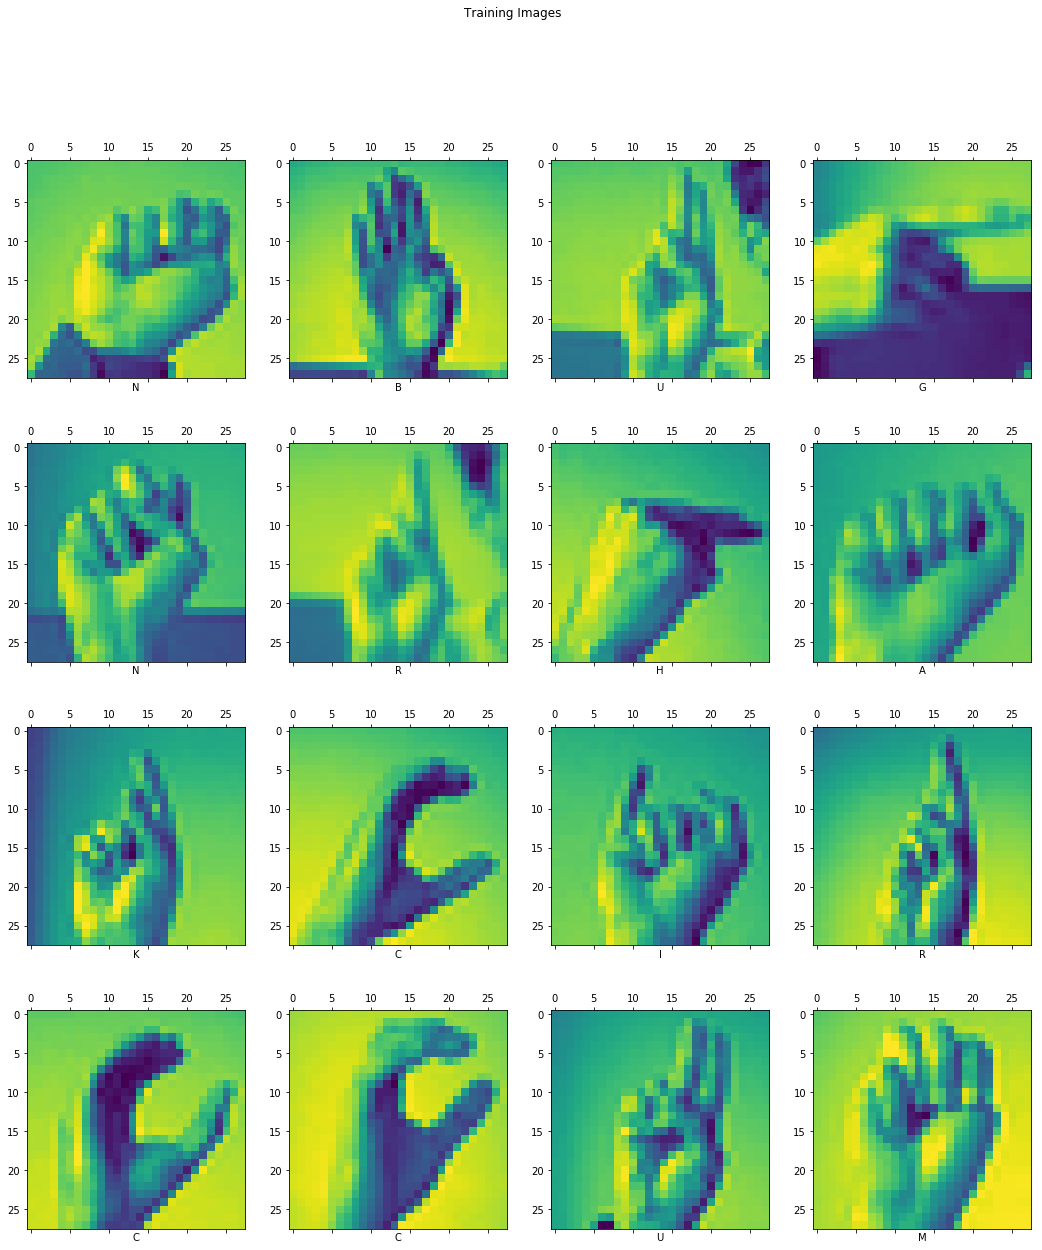

In [16]:
display(16,train_x,y_train, 'Training Images')

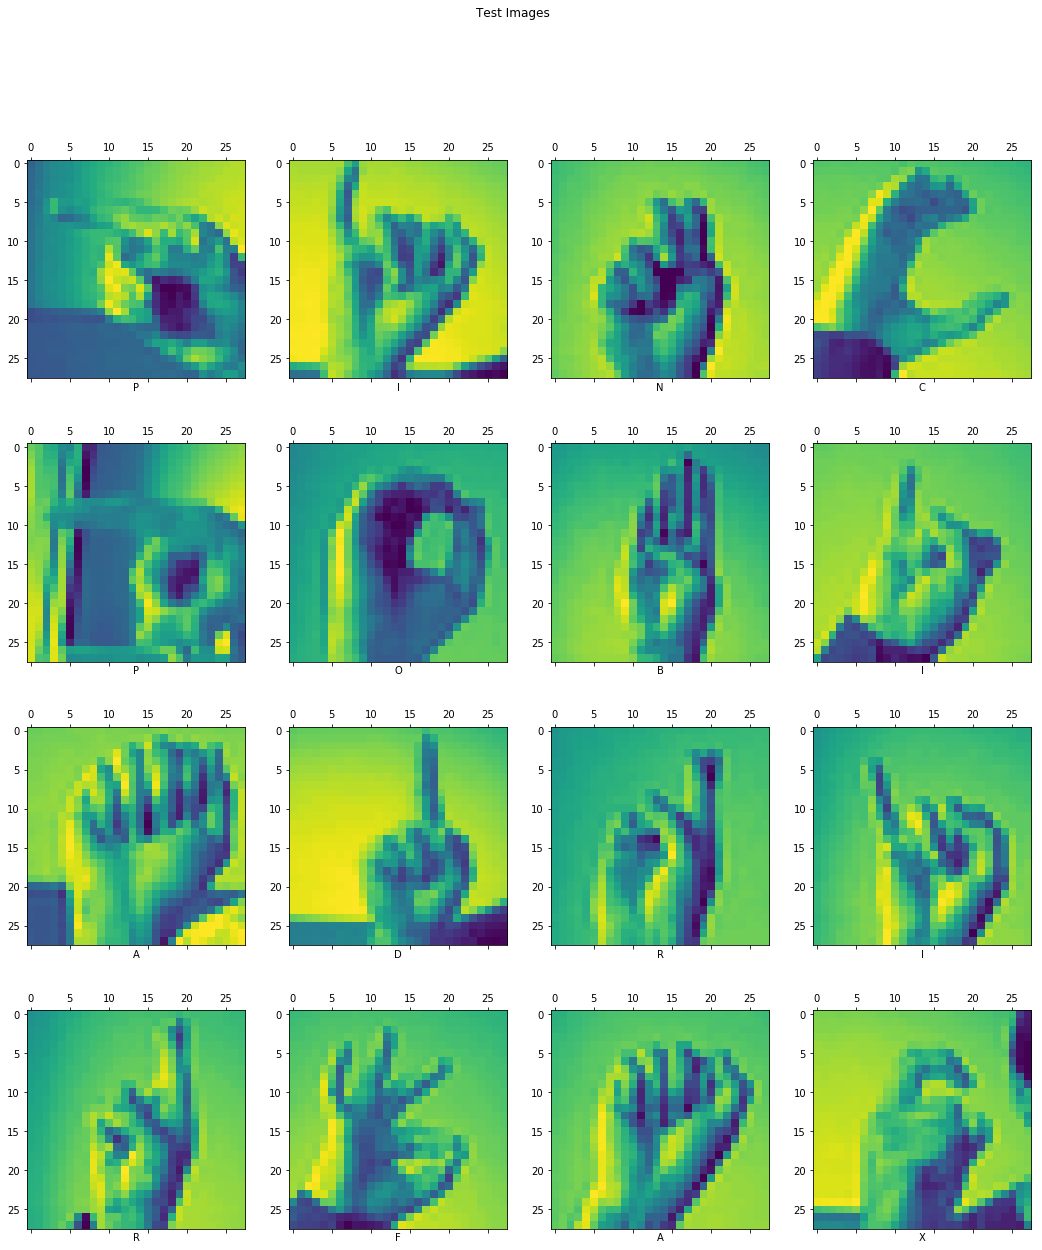

In [17]:
display(16,test_x, y_test, 'Test Images')

# Model

In [18]:
# hyperparameters
learning_rate = 0.001
batch_size = 256
epoch = 5000

In [19]:
# image dimensions and number of classes
image_width = 28
image_height = 28
color_channels = 1
n_classes = 25

In [20]:
# placeholders
X = tf.placeholder(tf.float32, shape = [None, image_width, image_height, color_channels]) 
Y = tf.placeholder(tf.float32, shape = [None, n_classes]) 

In [21]:
# parameters
weights =  { 'w1' : tf.Variable(tf.truncated_normal([3,3,1,16], stddev=0.1)),
             'w2' : tf.Variable(tf.truncated_normal([3,3,16,32], stddev=0.1)),
             'w3' : tf.Variable(tf.truncated_normal([3,3,32,64], stddev=0.1)),
             'w4' : tf.Variable(tf.truncated_normal([3,3,64,64], stddev=0.1)),
             'w5' : tf.Variable(tf.truncated_normal([2304,512], stddev=0.1)),
             'w6' : tf.Variable(tf.truncated_normal([512,512], stddev=0.1)),
             'w7' : tf.Variable(tf.truncated_normal([512,25], stddev=0.1))}

biases = {'b1' : tf.Variable(tf.truncated_normal([16], stddev=0.1)),
          'b2' : tf.Variable(tf.truncated_normal([32], stddev=0.1)),
          'b3' : tf.Variable(tf.truncated_normal([64], stddev=0.1)),
          'b4' : tf.Variable(tf.truncated_normal([64], stddev=0.1)),
          'b5' : tf.Variable(tf.truncated_normal([512], stddev=0.1)),
          'b6' : tf.Variable(tf.truncated_normal([512], stddev=0.1)),
          'b7' : tf.Variable(tf.truncated_normal([25], stddev=0.1))}             

In [22]:
def Network(x,weights,biases):
    conv1 = conv_layer(x,weights['w1'],biases['b1']) # input - 28x28x1, output - 28x28x16
    pool1 = maxpool_layer(conv1) # input - 28x28x16, output - 14x14x16
    conv2 = conv_layer(pool1,weights['w2'],biases['b2']) # input - 14x14x16, output - 14x14x32
    pool2 = maxpool_layer(conv2) # input - 14x14x32, output - 7x7x32
    conv3 = conv_layer(pool2,weights['w3'],biases['b3']) # input - 7x7x32, output - 7x7x64
    conv4 = conv_layer(conv3,weights['w4'],biases['b4']) # input - 7x7x64, output - 7x7x64
    pool3 = maxpool_layer(conv4, 2,1) # input - 7x7x64, output - 6x6x64
    
    flat = flatten(pool3) # input - 6x6x64, output - 2304
    
    fc1 = fc_layer(flat,weights['w5'],biases['b5']) # input - 2304, output - 512
    fc1 = tf.nn.relu(fc1)
    fc2 = fc_layer(fc1,weights['w6'],biases['b6']) # input - 512, output - 512
    fc2 = tf.nn.relu(fc2)
    fc3 = fc_layer(fc2,weights['w7'],biases['b7']) # input - 512, output - 25
    return fc3

In [23]:
# model output
pred = Network(X, weights, biases)
# loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = Y))
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
# minimize loss
train = optimizer.minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [24]:
correct_pred = tf.equal(tf.argmax(tf.nn.softmax(pred), 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [25]:
init = tf.global_variables_initializer()

# Train

In [26]:
with tf.Session() as sess:
    
    sess.run(init)
    
    cost_hist, acc_hist = [], []
    
    for epoch in range(1, epoch + 1):
        
        batch_x, batch_y = batch(batch_size, train_x, train_y)
        
        sess.run(train, feed_dict = { X : batch_x, Y : batch_y})
    
        if epoch % 200 == 0:
            c, acc = sess.run([loss, accuracy], feed_dict = { X : batch_x, Y : batch_y})
            cost_hist.append(c)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(c) + ', Accuracy: ' + str(acc))

    W = sess.run(weights)
    B = sess.run(biases)
    print('-' * 70)
    print('\nOptimization Finished\n')
    print('Accuracy on train data \t: ' + str(sess.run(accuracy, feed_dict = { X : train_x, Y :train_y}) * 100) + ' %')
    print('Accuracy on test data  \t: ' + str(sess.run(accuracy, feed_dict = { X : test_x, Y : test_y}) * 100) + ' %')
    

Epoch 200, Cost: 0.07159819, Accuracy: 0.98828125
Epoch 400, Cost: 0.0075660166, Accuracy: 1.0
Epoch 600, Cost: 0.0009189017, Accuracy: 1.0
Epoch 800, Cost: 0.0023505953, Accuracy: 1.0
Epoch 1000, Cost: 0.00045052293, Accuracy: 1.0
Epoch 1200, Cost: 0.00017909208, Accuracy: 1.0
Epoch 1400, Cost: 0.00011150488, Accuracy: 1.0
Epoch 1600, Cost: 6.581531e-05, Accuracy: 1.0
Epoch 1800, Cost: 4.10064e-05, Accuracy: 1.0
Epoch 2000, Cost: 4.411707e-05, Accuracy: 1.0
Epoch 2200, Cost: 5.3040738e-05, Accuracy: 1.0
Epoch 2400, Cost: 2.0857758e-05, Accuracy: 1.0
Epoch 2600, Cost: 1.8963954e-05, Accuracy: 1.0
Epoch 2800, Cost: 1.3284859e-05, Accuracy: 1.0
Epoch 3000, Cost: 1.0963752e-05, Accuracy: 1.0
Epoch 3200, Cost: 1.1382015e-05, Accuracy: 1.0
Epoch 3400, Cost: 9.017513e-06, Accuracy: 1.0
Epoch 3600, Cost: 4.2266743e-06, Accuracy: 1.0
Epoch 3800, Cost: 8.163665e-06, Accuracy: 1.0
Epoch 4000, Cost: 5.992265e-06, Accuracy: 1.0
Epoch 4200, Cost: 4.5135334e-06, Accuracy: 1.0
Epoch 4400, Cost: 2.641

# Cost Function Variation

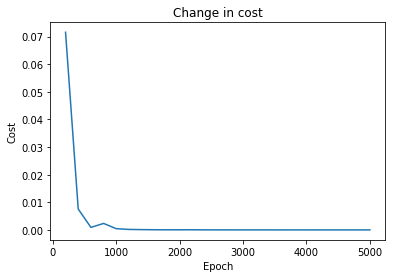

In [27]:
eps = list(range(200, epoch+200, 200))
plt.plot(eps, cost_hist)
plt.title("Change in cost")
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

# Saving Parameters

In [28]:
for key in weights.keys():
    weights[key] = tf.Variable(W[key])
    np.save(key, W[key])
for key in biases.keys():
    biases[key] = tf.Variable(B[key])
    np.save(key, B[key])

# Prediction on Test Images

In [29]:
logits = Network(X, weights, biases)
pred = tf.argmax(tf.nn.softmax(logits),1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(pred, tf.argmax(Y,1)), tf.float32))

In [30]:
init = tf.global_variables_initializer()

In [31]:
with tf.Session() as sess:
    sess.run(init)
    test_pred = sess.run(pred, feed_dict = {X : test_x})
    acc = sess.run(accuracy, feed_dict = {X : test_x, Y : test_y})
print(test_pred[0:10])
print('Accuracy on test data  \t: ' + str(acc * 100) + ' %')

[ 6  5 10  0  3 21 10 14  3  7]
Accuracy on test data  	: 95.10596990585327 %


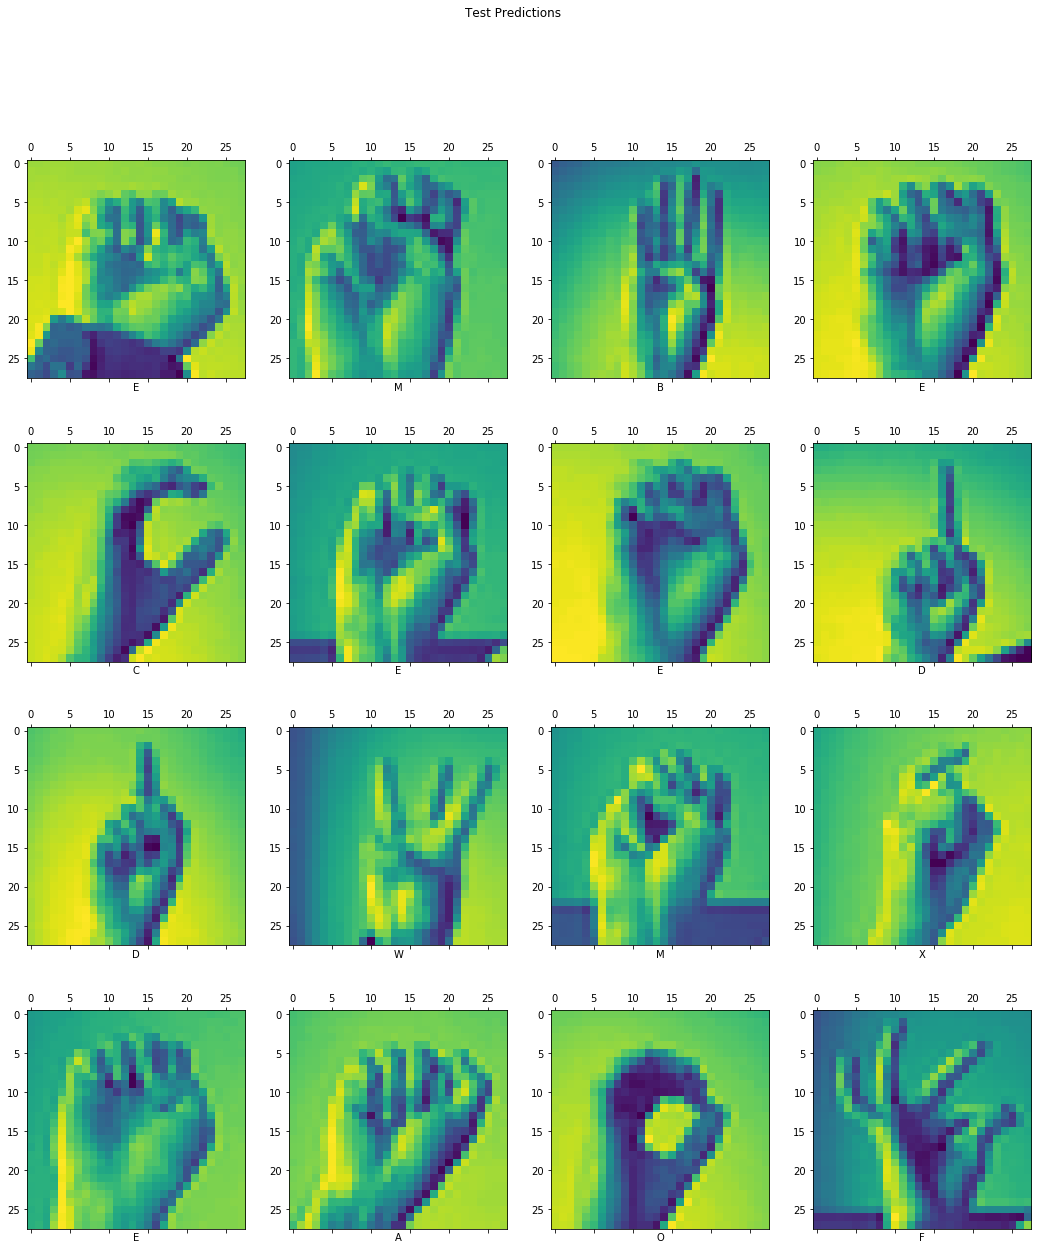

In [32]:
display(16,test_x,test_pred, 'Test Predictions')